# Car Price Prediction – Machine Learning Project

This project aims to develop a machine learning model capable of accurately **predicting the price of used cars** based on various technical and categorical attributes such as mileage, year, engine power, fuel type, and brand.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Loaded Dataset and Convert 

In [2]:
df = pd.read_excel("cars.xlsx")
df.to_csv('cars.csv', index=False)

df = pd.read_csv("cars.csv")
print("\nDataset Loaded. Shape:", df.shape)


Dataset Loaded. Shape: (65535, 10)


In [3]:
print('\nInfo:')
print(df.info())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            65535 non-null  object 
 1   model            65535 non-null  object 
 2   price_in_pln     65535 non-null  float64
 3   mileage          65535 non-null  object 
 4   gearbox          65535 non-null  object 
 5   engine_capacity  65535 non-null  object 
 6   fuel_type        65535 non-null  object 
 7   city             65535 non-null  object 
 8   voivodeship      65535 non-null  object 
 9   year             65535 non-null  object 
dtypes: float64(1), object(9)
memory usage: 5.0+ MB
None


In [4]:
df.head()

,brand,model,price_in_pln,mileage,gearbox,engine_capacity,fuel_type,city,voivodeship,year
0,alfa-romeo,Alfa Romeo Spider 2.0-16 TSpark,14700.0,133760,manual,1970,Benzyna,Łask,Łódzkie,1998
1,alfa-romeo,Alfa Romeo GTV 2.0 16v TSpark,14000.0,133760,manual,1970,Benzyna,Mława,Mazowieckie,1998
2,alfa-romeo,Alfa Romeo 164 2.0 TSpark Super,4500.0,227000,manual,1970,Benzyna,Chełmża,Kujawsko-pomorskie,1996
3,alfa-romeo,Alfa Romeo Spider 2.0 TSpark,17100.0,227000,manual,1970,Benzyna,Jasło,Podkarpackie,1996
4,alfa-romeo,Alfa Romeo 156 1.6 TSpark 16v,3900.0,239000,manual,1995,Benzyna+LPG,Pabianice,Łódzkie,1995


## Data Exploration and Preprocessing
- Removing rows with missing values
- Removing rows with misplaced values
- Removing rows with duplicate values
- Outlier detection and filtering

In [5]:
# Look for inappropriate values in the dataset
def clean_a_column(df, column_name, should_be_numeric):    
    if should_be_numeric:
        # Keep only rows where the value is numeric
        df = df[pd.to_numeric(df[column_name], errors='coerce').notna()].copy()
        df[column_name] = pd.to_numeric(df[column_name])
        # print(f"After removing non-numeric {column_name} rows. Shape:", df.shape)
    else:
        # Keep only rows where the value is NOT numeric
        df = df[pd.to_numeric(df[column_name], errors='coerce').isna()].copy()
        df[column_name] = df[column_name].astype(str)
        # print(f"After removing numeric {column_name} values. Shape:", df.shape)
    return df

def clean_all_columns(df):
    numeric_columns = ['mileage', 'engine_capacity', 'year', 'price_in_pln']
    categorical_columns = ['brand', 'model', 'gearbox', 'fuel_type', 'city', 'voivodeship']    
    for num_col in numeric_columns:
        print(f"Processing numeric column: {num_col}")
        df = clean_a_column(df, num_col, True)
    for cat_col in categorical_columns:
        print(f"Processing categorical column: {cat_col}")
        df = clean_a_column(df, cat_col, False)
    return df

def remove_outliers_iqr(df, columns, var=1.5):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - var * IQR
        upper_bound = Q3 + var * IQR
        before = df.shape[0]
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        after = df.shape[0]
        print(f"{col}: removed {before - after} outliers")
    return df


df = clean_all_columns(df)



Processing numeric column: mileage
Processing numeric column: engine_capacity
Processing numeric column: year
Processing numeric column: price_in_pln
Processing categorical column: brand
Processing categorical column: model
Processing categorical column: gearbox
Processing categorical column: fuel_type
Processing categorical column: city
Processing categorical column: voivodeship


### Boxplots of Numerical Features

The following visualization displays **boxplots** for all numerical features in the dataset. Boxplots are useful for:

* Showing the **distribution and spread** of values
* Highlighting **outliers**
* Comparing **central tendency and variability** across features

This overview helps identify variables with skewed distributions or extreme values that may require special treatment during preprocessing.



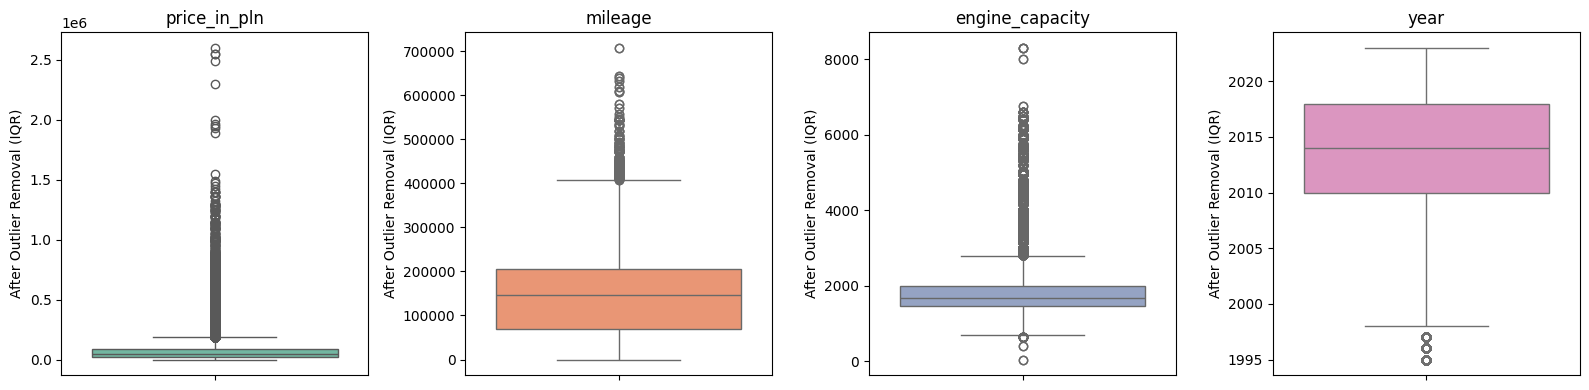

In [6]:
# Selecting numerical columns for boxplot visualization
numerical_cols = df.select_dtypes(include='number').columns
n = len(numerical_cols)


rows = 3  # "before", and "after"
cols = n  # Number of rows needed for the boxplots
palette = sns.color_palette("Set2", n_colors=n)

# Visualizza solo i boxplot degli outlier rimossi tramite IQR
fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
for col_idx, col_name in enumerate(numerical_cols):
    sns.boxplot(y=df[col_name], color=palette[col_idx], ax=axes[col_idx])
    axes[col_idx].set_title(col_name)
    axes[col_idx].set_ylabel("After Outlier Removal (IQR)")
    axes[col_idx].set_xlabel("")
plt.tight_layout()
plt.show()


###  Outliers Manual Removal

In [7]:
# Removing luxury cars -> outliers
df = df[df['price_in_pln'] <= 1500000]
# Removing cars with mileage over 600000 -> outliers
df = df[df['mileage'] <= 600000]
# Removing engine capacity clear data errors over 8000 -> outliers
df = df[df['engine_capacity'] <= 8000]
df = df[df['engine_capacity'] > 0]
# Removing duplicate rows
df.drop_duplicates(inplace=True)

### Data Visualization – Price, Mileage and Year

In this section, we visualize the distribution and relationships of key numerical variables in the dataset that are expected to influence car prices.

* **Price distribution** helps to understand the overall price range and skewness.
* **Mileage distribution** gives insight into how used the cars are.
* **Scatter plots** between:

  * **Price and Mileage** help detect depreciation trends.
  * **Price and Year** reveal how newer cars retain higher value.

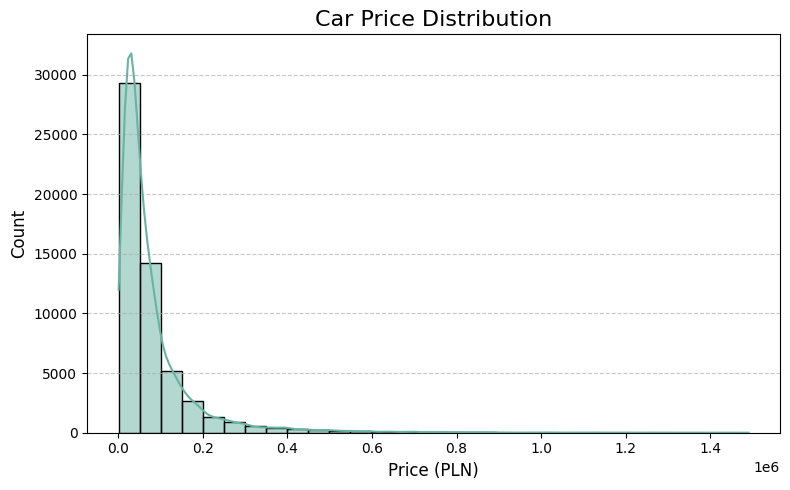

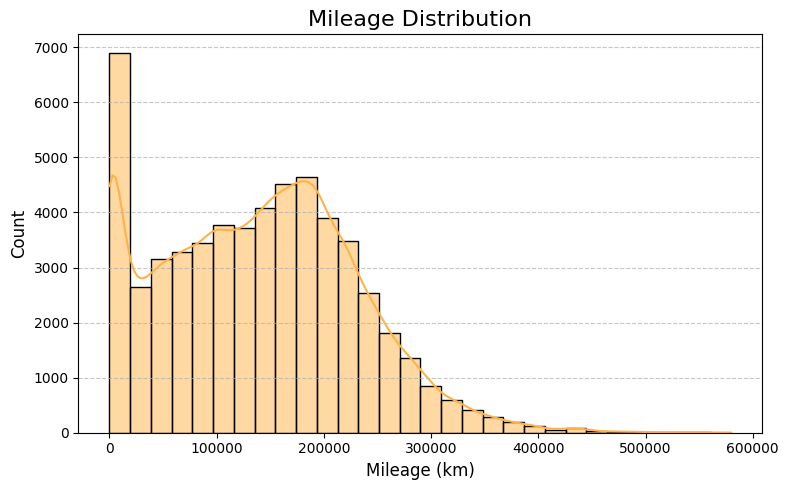

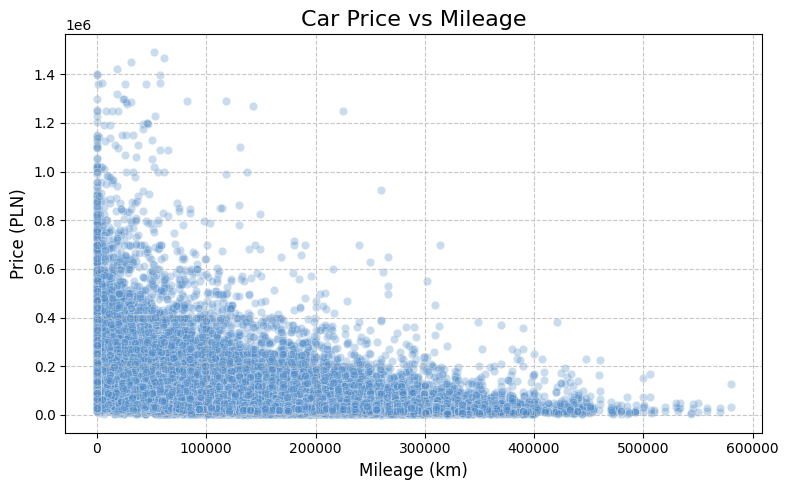

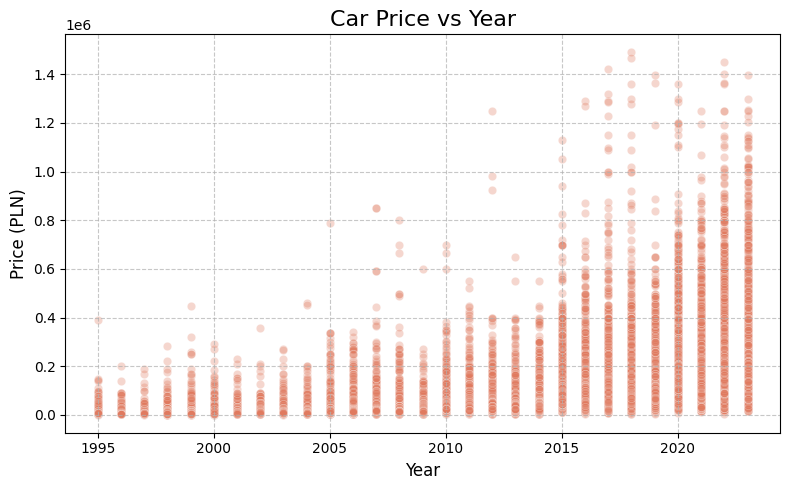

In [8]:
# Price distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['price_in_pln'], bins=30, kde=True, color="#69b3a2", edgecolor="black")
plt.title("Car Price Distribution", fontsize=16)
plt.xlabel("Price (PLN)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Mileage distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['mileage'], bins=30, kde=True, color="#ffb347", edgecolor="black")
plt.title("Mileage Distribution", fontsize=16)
plt.xlabel("Mileage (km)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Price vs Mileage
plt.figure(figsize=(8, 5))
sns.scatterplot(x='mileage', y='price_in_pln', data=df, alpha=0.3, color="#4f8bc9")
plt.title("Car Price vs Mileage", fontsize=16)
plt.xlabel("Mileage (km)", fontsize=12)
plt.ylabel("Price (PLN)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Price vs Year
plt.figure(figsize=(8, 5))
sns.scatterplot(x='year', y='price_in_pln', data=df, alpha=0.3, color="#e07a5f")
plt.title("Car Price vs Year", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Price (PLN)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Feature Selection and Engineering
The feature under the name of *'model'* actually contains a lot of information about the car, therefore we thought it would be helpful to extract the actual model of the car and the configuration of the car. An example of this is: from the string *'Alfa Romeo GTV 2.0 16v TSpark'* we extract *'GTV'* as the model, since the brand is already specified by the first column, and *'2.0 16v TSpark'* as the configuration. The configuration column is later transformed into a numerical, binary, feature by checking whether the configuration is present, 1, or not, 0.

- Encoding categorical features: 
  - One-hot encoding for fuel type and gearbox
  - Target encoding for brand and model (considered as a single feature)
- Scaling numerical features:
  - Min-Max Normalization for numerical features (engine capacity and age)
  - Log normalization for mileage due to skewness

In [9]:
def process_model_name(model, brand):
    model_parts = model.replace('ë', 'e').replace('+', ' ').split()
    brand_words = []
    if brand == 'land-rover':
        brand_words.extend(['land', 'rover', 'range'])
    elif brand.lower() == 'mercedes-benz':
        brand_words.append(brand.replace('-', ' '))
    else:
        brand_words.extend(brand.split('-'))
    
    model_parts_copy = model_parts.copy()
    for w in model_parts_copy:
        w_for_comparison = w.replace('-', ' ')
        if any(brand_part.lower() == w_for_comparison.lower() for brand_part in brand_words):
            model_parts.remove(w)
    
    if len(model_parts) == 0:
        return "Unknown", ""
    
    # Special handling for Land Rover Range Rover
    if brand == 'land-rover' and 'Range' in model and 'Rover' in model:
        original_parts = model.split()
        range_rover_end = -1
        for i, part in enumerate(original_parts):
            if part.lower() == 'rover' and i > 0 and original_parts[i-1].lower() == 'range':
                range_rover_end = i
                break
        if range_rover_end != -1 and range_rover_end + 1 < len(original_parts):
            next_part = original_parts[range_rover_end + 1]
            # Check if the next part is numeric (contains digits)
            if any(char.isdigit() for char in next_part):
                model_name = ['Range', 'Rover']
            else:
                model_name = [next_part]
        else:
            model_name = ['Range', 'Rover']
    else:
        model_name = [model_parts[0]]
    # Special handling for BMW Series
    if brand.lower() == 'bmw' and model_name[0].lower() == 'seria':
        if len(model_parts) > 1:
            model_name.append(model_parts[1])            
    # Special handling for Mercedes-Benz Classes
    if brand.lower() == 'mercedes-benz' and model_name[0].lower() == 'klasa':
        if len(model_parts) > 1:
            model_name.append(model_parts[1])       

    return ' '.join(model_name), ' '.join([w for w in model_parts if w not in model_name])


df['model_cleaned'] = df['model']
df['configuration'] = df['model']
for brand in df['brand'].unique():
    # print(f"Processing brand: {brand}")
    mask = df['brand'] == brand
    # Remove brand name from model
    processed_models = df.loc[mask, 'model_cleaned'].apply(lambda x: process_model_name(x, brand))
    df.loc[mask, 'model_cleaned'] = [result[0] for result in processed_models]
    df.loc[mask, 'configuration'] = [result[1] for result in processed_models]
    # Remove rows where model_cleaned is 'Unknown'
    df = df[df['model_cleaned'] != 'Unknown']
    # Save if has configuration
    df['optional'] = (df['configuration'] != '').astype(int)


# ---------------------- Ordinal encoding for gearbox ----------------------
gearbox_mapping = {value: i for i, value in enumerate(df['gearbox'].unique())}
# # print("Gearbox mapping:", gearbox_mapping)
df['gearbox'] = df['gearbox'].map(gearbox_mapping)


# ---------------------- Dropping useless features ----------------------
df.drop(['city', 'voivodeship'], axis=1, inplace=True)

In [10]:
# Split df in train, val and test sets
X = df.drop('price_in_pln', axis=1)
y = df['price_in_pln']


temp_df, val_df, y_temp, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
train_df, test_df, y_train, y_test = train_test_split(temp_df, y_temp, test_size=0.1, random_state=42)

print("\nTrain set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)


# One hot encode the 'fuel_type' column
encoder = OneHotEncoder(sparse_output=False, drop='first')
fuel_encoded_train = encoder.fit_transform(train_df[['fuel_type']])
feature_names = encoder.get_feature_names_out(['fuel_type'])
fuel_encoded_val = encoder.transform(val_df[['fuel_type']])
fuel_encoded_test = encoder.transform(test_df[['fuel_type']])
train_encoded = pd.DataFrame(fuel_encoded_train, columns=feature_names, index=train_df.index).astype(int)
val_encoded = pd.DataFrame(fuel_encoded_val, columns=feature_names, index=val_df.index).astype(int)
test_encoded = pd.DataFrame(fuel_encoded_test, columns=feature_names, index=test_df.index).astype(int)

train_df = pd.concat([train_df.drop('fuel_type', axis=1), train_encoded], axis=1)
val_df = pd.concat([val_df.drop('fuel_type', axis=1), val_encoded], axis=1)
test_df = pd.concat([test_df.drop('fuel_type', axis=1), test_encoded], axis=1)



# ---------------------- Target encoding for brand and model ----------------------
# Compute target encoding, on training data, for brand and model
train_data = pd.concat([train_df, y_train], axis=1)
brand_model_means = train_data.groupby(['brand', 'model_cleaned'])['price_in_pln'].mean()
def apply_target_encoding(X_set, target_means, fallback_value):
    return X_set.apply(
        lambda row: target_means.get((row['brand'], row['model_cleaned']), fallback_value), 
        axis=1
    )
fallback = y_train.mean()  # Use training mean as fallback
train_df['brand_model_target'] = apply_target_encoding(train_df, brand_model_means, fallback)
val_df['brand_model_target'] = apply_target_encoding(val_df, brand_model_means, fallback)
test_df['brand_model_target'] = apply_target_encoding(test_df, brand_model_means, fallback)



# ---------------------- Normalize mileage, age and engine capacity ----------------------
# Compute age column
last_year = train_df['year'].max()
train_df['age'] = last_year - train_df['year']
val_df['age'] = last_year - val_df['year']
test_df['age'] = last_year - test_df['year']

# In order to avoid data leakage, we will normalize the data ONLY ACCORDING to values in the train set.
max_age = train_df['age'].max()
min_age = train_df['age'].min()
max_mileage = train_df['mileage'].max()
min_mileage = train_df['mileage'].min()
max_engine_capacity = train_df['engine_capacity'].max()
min_engine_capacity = train_df['engine_capacity'].min()

# Normalize mileage, age and engine capacity using train set min and max
train_df['age_normalized'] = (train_df['age'] - min_age) / (max_age - min_age)
val_df['age_normalized'] = (val_df['age'] - min_age) / (max_age - min_age)
test_df['age_normalized'] = (test_df['age'] - min_age) / (max_age - min_age)

train_df['mileage_normalized'] = np.log1p(train_df['mileage'])
val_df['mileage_normalized'] = np.log1p(val_df['mileage'])
test_df['mileage_normalized'] = np.log1p(test_df['mileage'])

train_df['engine_capacity_normalized'] = (df['engine_capacity'] - min_engine_capacity) / (max_engine_capacity - min_engine_capacity)
val_df['engine_capacity_normalized'] = (val_df['engine_capacity'] - min_engine_capacity) / (max_engine_capacity - min_engine_capacity)
test_df['engine_capacity_normalized'] = (test_df['engine_capacity'] - min_engine_capacity) / (max_engine_capacity - min_engine_capacity)

train_df.drop(['model', 'configuration', 'year', 'age', 'mileage', 'engine_capacity', 'model_cleaned', 'brand'], axis=1, inplace=True)
val_df.drop(['model', 'configuration', 'year', 'age', 'mileage', 'engine_capacity', 'model_cleaned', 'brand'], axis=1, inplace=True)
test_df.drop(['model', 'configuration', 'year', 'age', 'mileage', 'engine_capacity', 'model_cleaned', 'brand'], axis=1, inplace=True)

train_df.to_csv("cars_cleaned.csv", index=False)
train_df.info()


Train set shape: (45261, 10)
Validation set shape: (5588, 10)
Test set shape: (5030, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 45261 entries, 2613 to 55762
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gearbox                     45261 non-null  int64  
 1   optional                    45261 non-null  int32  
 2   fuel_type_Benzyna+CNG       45261 non-null  int32  
 3   fuel_type_Benzyna+LPG       45261 non-null  int32  
 4   fuel_type_Diesel            45261 non-null  int32  
 5   fuel_type_Elektryczny       45261 non-null  int32  
 6   fuel_type_Hybryda           45261 non-null  int32  
 7   brand_model_target          45261 non-null  float64
 8   age_normalized              45261 non-null  float64
 9   mileage_normalized          45261 non-null  float64
 10  engine_capacity_normalized  45261 non-null  float64
dtypes: float64(4), int32(6), int64(1)
memory usage: 3.1 MB


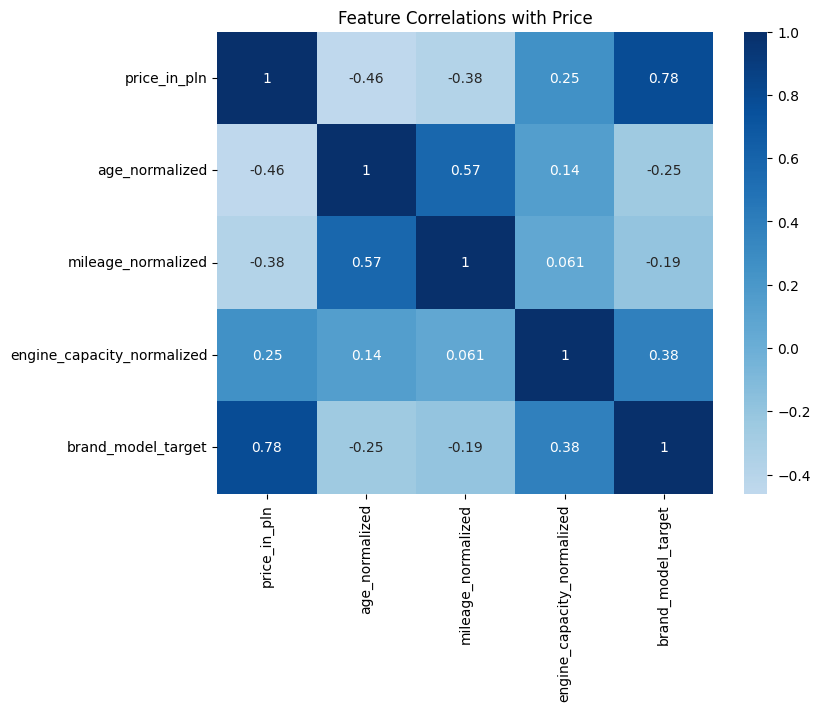

In [11]:
# Calculate correlation matrix
numeric_cols = ['price_in_pln', 'age_normalized', 'mileage_normalized', 'engine_capacity_normalized', 'brand_model_target']
train_data = pd.concat([train_df, y_train], axis=1)
correlation_matrix = train_data[numeric_cols].corr()

# Visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', center=0)
plt.title('Feature Correlations with Price')
plt.show()

## Model Development and Evaluation


In this section, we define a dictionary of machine learning regression models, including decision trees, random forests, gradient boosting, and XGBoost. Each model is associated with a specific hyperparameter grid, which will be used in combination with `GridSearchCV` 

For each model:

* The training is performed using the training set (`train_df`, `y_train`)
* The best model is selected based on the highest R2 score
* Predictions are made on the test set (`test_df`)
* Performance metrics are computed:
  * **MAE** (Mean Absolute Error)
  * **MSE** (Mean Squared Error)
  * **R2 score**
* The trained model is saved using `joblib` for later use





In [28]:
import os
from joblib import load

# Crea la directory se non esiste
os.makedirs("model_weights", exist_ok=True)

# Random seed
random_state = 42

# Dictionary of models with parameters
models = {
    'DecisionTree': {
        'name': 'Decision Tree',
        'estimator': DecisionTreeRegressor(random_state=random_state),
        'param': [{'max_depth': [5, 10, 20], 'min_samples_split': [2, 5, 10]}]
    },
    'RandomForest': {
        'name': 'Random Forest',
        'estimator': RandomForestRegressor(random_state=random_state),
        'param': {
            'n_estimators': [150],
            'max_depth': [10],
        }
    },
    'GradientBoosting': {
        'name': 'Gradient Boosting',
        'estimator': GradientBoostingRegressor(random_state=random_state),
        'param': {
            'n_estimators': [500],
            'learning_rate': [0.2],
            'max_depth': [3]
        }
    }, 
    'XGBoost': {
    'name': 'XGBoost Regressor',
    'estimator': XGBRegressor(objective='reg:squarederror', random_state=random_state),
    'param': {
        'n_estimators': [200, 500],
        'max_depth': [5],
        'learning_rate': [0.05, 0.1],
        'subsample': [1.0]
    }
}
}
result = []

for key, model_info in models.items():
    print(f"\nTraining model: {model_info['name']}")
    
    estimator = model_info['estimator']
    param_grid = model_info['param']
    
    if param_grid: 
        grid = GridSearchCV(estimator, param_grid, cv=3, scoring='r2', n_jobs=-1)
        grid.fit(train_df, y_train)
        best_model = grid.best_estimator_
        print(f"Best parameters: {grid.best_params_}")
    
    else:
        best_model = estimator.fit(train_df, y_train)

    # Save the model performance
    dump(best_model, f"model_weights/{key}_model.joblib")
    
    y_pred = best_model.predict(test_df)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    result.append({
        'model': model_info['name'],
        'mae': mae,
        'mse': mse,
        'r2': r2
    })
    print(f"\nMAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.4f}")


# Show results
results_df = pd.DataFrame(result)
results_df = results_df.sort_values(by='r2', ascending=False)
print("\nModel Performance Summary:")
print(results_df)

best_model_name = results_df.iloc[0]['model']
best_model_key = [k for k, v in models.items() if v['name'] == best_model_name][0]
best_model = load(f"model_weights/{best_model_key}_model.joblib")
dump(best_model, "model_weights/Best_model.joblib")
print(f"\nBest model ({best_model_name}) saved as: model_weights/Best_model.joblib")


Training model: Decision Tree
Best parameters: {'max_depth': 10, 'min_samples_split': 10}

MAE: 20604.03, MSE: 1926096196.06, R2: 0.8440

Training model: Random Forest
Best parameters: {'max_depth': 10, 'n_estimators': 150}

MAE: 19949.69, MSE: 1757441071.87, R2: 0.8577

Training model: Gradient Boosting
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500}

MAE: 20120.13, MSE: 1766041300.27, R2: 0.8570

Training model: XGBoost Regressor
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}

MAE: 21011.58, MSE: 2111180031.90, R2: 0.8291

Model Performance Summary:
               model           mae           mse        r2
1      Random Forest  19949.688872  1.757441e+09  0.857696
2  Gradient Boosting  20120.127923  1.766041e+09  0.856999
0      Decision Tree  20604.033257  1.926096e+09  0.844039
3  XGBoost Regressor  21011.580547  2.111180e+09  0.829052

Best model (Random Forest) saved as: model_weights/Best_model.joblib

## Prediction and Interpretation

This section demonstrates how the trained machine learning models are used to predict car prices on unseen test data. We compare the predictions of different models (Decision Tree, Random Forest, Gradient Boosting, and XGBoost) against the actual prices for a random selection of test samples.

The results are visualized using bar charts, where each sample's true price and predicted prices from all models are shown side by side. This allows for a direct comparison of model performance on individual cases and helps to interpret the strengths and weaknesses of each approach.


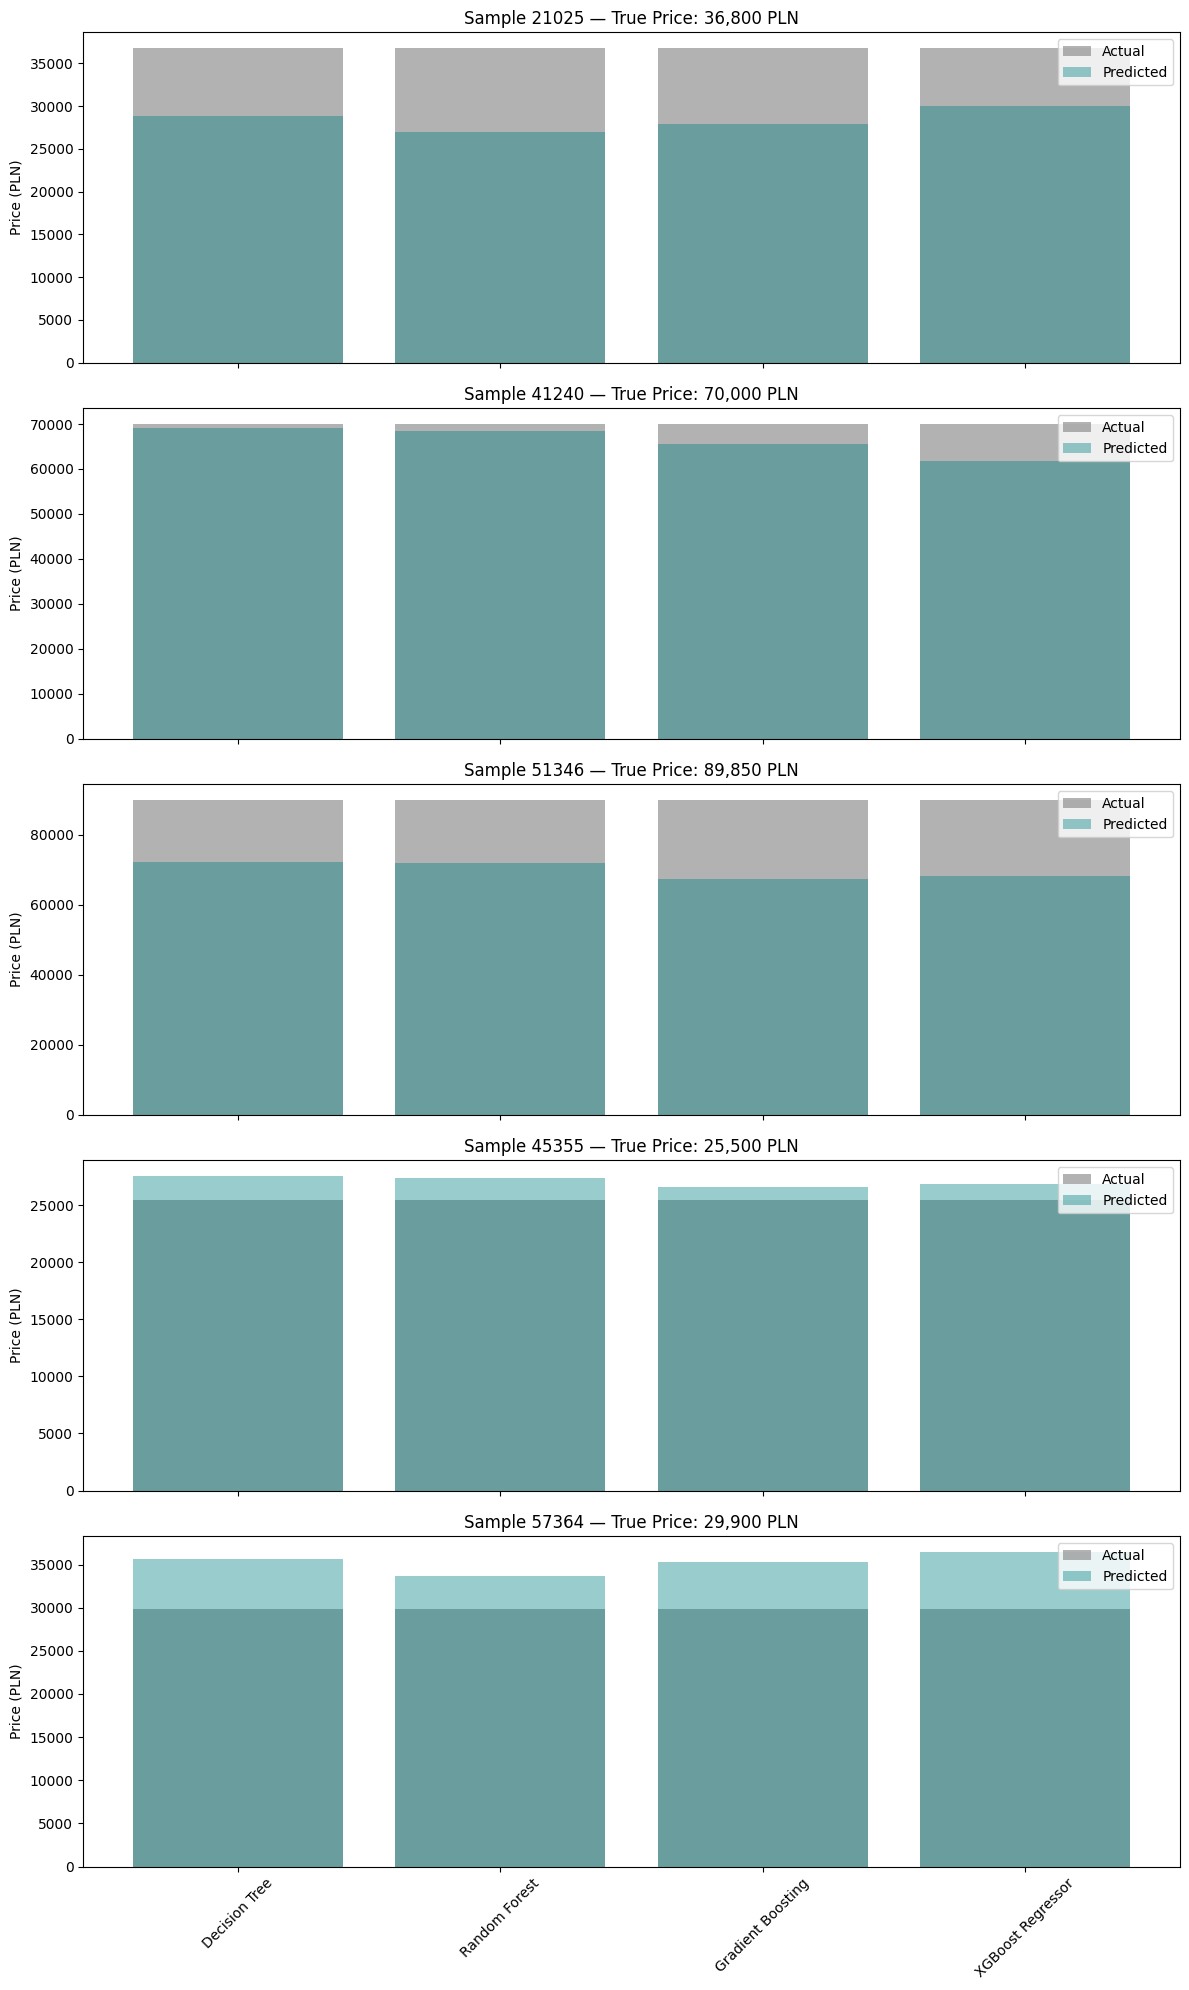

In [31]:
from joblib import load

# Number of test samples to compare
n_samples = 5

# Randomly select samples from the test set
random_indices = test_df.sample(n=n_samples, random_state=np.random.randint(0, 10000)).index
x_samples = test_df.loc[random_indices]
y_samples = y_test.loc[random_indices]

# Store prediction results
comparison_data = []

# Loop through all models and make predictions
for model_key, model_info in models.items():
    model_name = model_info['name']
    model_path = f"model_weights/{model_key}_model.joblib"

    try:
        model = load(model_path)
        y_preds = model.predict(x_samples)

        for i, idx in enumerate(random_indices):
            comparison_data.append({
                'model': model_name,
                'sample_index': idx,
                'actual_price': round(y_samples.loc[idx], 2),
                'predicted_price': round(y_preds[i], 2),
                'error': round(y_preds[i] - y_samples.loc[idx], 2)
            })

    except Exception as e:
        print(f"Error loading model {model_key}: {e}")

# Create a comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)

# --- Visualization: Bar chart per sample ---
fig, axes = plt.subplots(n_samples, 1, figsize=(12, 4 * n_samples), sharex=True)

for i, idx in enumerate(random_indices):
    ax = axes[i]
    sample_data = comparison_df[comparison_df['sample_index'] == idx]

    # Actual vs predicted bars
    ax.bar(sample_data['model'], sample_data['actual_price'], label='Actual', alpha=0.6, color='gray')
    ax.bar(sample_data['model'], sample_data['predicted_price'], label='Predicted', alpha=0.4, color='teal')

    ax.set_title(f"Sample {idx} — True Price: {y_samples.loc[idx]:,.0f} PLN")
    ax.set_ylabel("Price (PLN)")
    ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show the table summary
# print("\nComparison of Models on Sample:")
# print(comparison_df)
# results_df = pd.DataFrame(result)
# results_df = results_df.sort_values(by='r2', ascending=False)
#print("\nModel Performance Summary:")
#print(results_df)






### Load and Evaluation the best model

This cell demonstrates how to **load the best-performing model**, previously saved after model evaluation, and use it to **predict car prices** on a random subset of test samples. The selected model is expected to be stored as a `.joblib` file in the `model_weights/` directory.

It not necessary trein all models.

Once loaded, the model is used to:

* Predict prices on a small number of test samples (randomly selected between 5 and 15).
* Print a side-by-side comparison of actual vs. predicted prices.
* Report absolute error and percentage deviation for each sample.

This step simulates the **inference phase** of the pipeline, and gives insight into how well the model generalizes on unseen data.



In [33]:
from joblib import load
import os
import numpy as np

def load_best_model():
    """
    Load the best pre-trained model from the specified file.
    If the model file does not exist, raise an error with instructions on how to generate it.
    If the model file exists, load and return the model.
    """
    best_model_file = "model_weights/Best_model.joblib"
    
    if os.path.exists(best_model_file):
        print("Laod pre-trained model...")
        return load(best_model_file)
    else:
        print("Model not found. Generating instructions...")
        raise FileNotFoundError(f"""Model not founde  {best_model_file}.
                                
        For generating the model, follow these steps:
        1. Ensure you have the 'cars_cleaned.csv' file in the current directory.
        2. Run the 'Model Development and Evaluation' section of the notebook.
        3. The model will be saved automatically as '{best_model_file}'.""")

# Load the best model and make predictions on test samples
try:
    best_model_loaded = load_best_model()
    
    n_test_samples = np.random.randint(5, 15)  # Randomly choose number of test samples
    x_samples = test_df.iloc[:n_test_samples]
    y_trues = y_test.iloc[:n_test_samples]
    y_preds = best_model_loaded.predict(x_samples)
    
    
    print(f"Result for the first {n_test_samples} test samples:")

    print("-" * 60)
    for i in range(n_test_samples):
        error = abs(y_preds[i] - y_trues.iloc[i])
        error_percent = (error / y_trues.iloc[i]) * 100
        print(f"Sample {x_samples.index[i]}:")
        print(f"  Price Real:    {y_trues.iloc[i]:>10,.2f} PLN")
        print(f"  Price Predicted: {y_preds[i]:>10,.2f} PLN")
        print(f"  Abs. Error: {error:>10,.2f} PLN ({error_percent:.1f}%)")
        print()

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"Error to load data: {e}")


Laod pre-trained model...
Result for the first 9 test samples:
------------------------------------------------------------
Sample 46464:
  Price Real:     22,222.00 PLN
  Price Predicted:  21,066.76 PLN
  Abs. Error:   1,155.24 PLN (5.2%)

Sample 14857:
  Price Real:     33,900.00 PLN
  Price Predicted:  27,402.22 PLN
  Abs. Error:   6,497.78 PLN (19.2%)

Sample 42858:
  Price Real:      7,100.00 PLN
  Price Predicted:   7,893.93 PLN
  Abs. Error:     793.93 PLN (11.2%)

Sample 13447:
  Price Real:     28,500.00 PLN
  Price Predicted:  27,418.54 PLN
  Abs. Error:   1,081.46 PLN (3.8%)

Sample 3350:
  Price Real:     85,500.00 PLN
  Price Predicted: 127,063.89 PLN
  Abs. Error:  41,563.89 PLN (48.6%)

Sample 40782:
  Price Real:     43,990.00 PLN
  Price Predicted:  31,353.35 PLN
  Abs. Error:  12,636.65 PLN (28.7%)

Sample 51602:
  Price Real:     82,900.00 PLN
  Price Predicted:  90,747.71 PLN
  Abs. Error:   7,847.71 PLN (9.5%)

Sample 22647:
  Price Real:     77,900.00 PLN
  Price 


This cell simulates the inference phase, showing how well the model generalizes to unseen data.

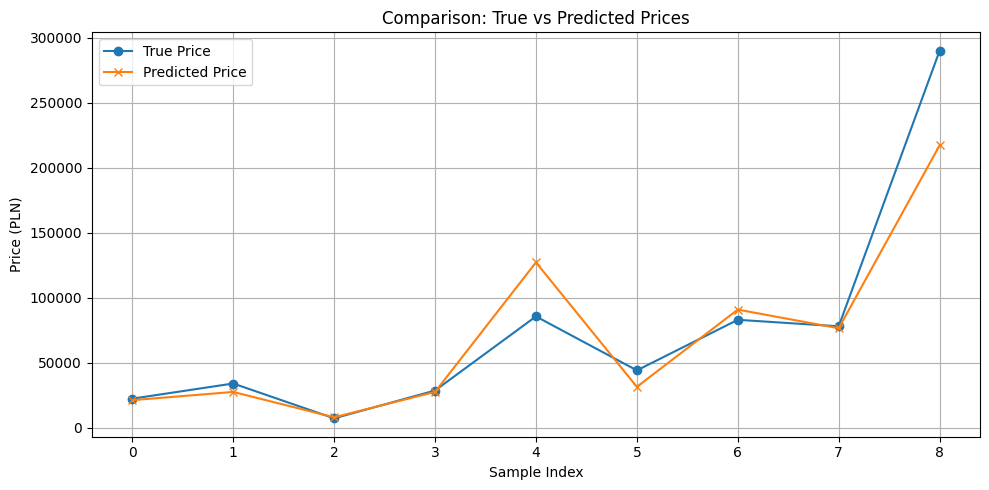

In [37]:
results_list = []

for i in range(n_test_samples):
    error = abs(y_preds[i] - y_trues.iloc[i])
    error_percent = (error / y_trues.iloc[i]) * 100

    results_list.append({
        "index": x_samples.index[i],
        "actual_price": y_trues.iloc[i],
        "predicted_price": y_preds[i],
        "abs_error": error,
        "error_%": error_percent
    })


plt.figure(figsize=(10, 5))
plt.plot(y_trues.values, label="True Price", marker='o')
plt.plot(y_preds, label="Predicted Price", marker='x')
plt.title("Comparison: True vs Predicted Prices")
plt.xlabel("Sample Index")
plt.ylabel("Price (PLN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

